# Initialize

**To use:**
1. Adjust the mix variable for each data set
2. Drag and drop all of the data that is to be fit and analyzed.
    1. the program auto deletes all unnessary files (.SPE, .dat, .log)
    1. for days with multiple sets of conditions run, only drag and drop one data for one set of conditions at a time (easiest method). There are also optional lines in the 'Analysis' section that can be used to select 'Runs # through #'

In [18]:
import os, sys
import numpy as np
import scipy as sp
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from IPython.display import display
import xlwt, xlrd
from pylab import*

print(os.getcwd()) # Double check that data is in this folder

/Users/kzuraski/Desktop/LIF/Data/Temp


# Variables

In [19]:
mix = .4895 # Adjust the mix ratio here

plot_col = 2
#time_step = 50 #time step in between each data point in micro seconds (us)
time_idx_st = 5
time_idx_en = 900

cent_WL = 450 #Centre wavelength of the CCD, in nm
WL_cal = 0.103 #nm per pixel
WL_int = cent_WL - 69.57 #nm offset
CCD_size = 1340 #CCD total pixel count 

# Eliminate Unnecessary Files

In [27]:
for item in os.listdir(os.getcwd()):
    if item.endswith(".SPE") or item.endswith(".log") or item.endswith(".dat"):
        if not item.endswith("average.log"):
            if not item.endswith("FINAL.dat"):
                os.remove(os.path.join(os.getcwd(),item))     

# Import CCD data and average

In [28]:
filelist = []
avg_arr = []
temp_arr = []
cur_Par = 0
WL_arr = []

file_preff = "ICCD_" #File preffix - change here
summ_file_base = "AVG_CCD_" #Output file base
summ_file_ext = ".txt" #Output file extension

#Create WL array
func1 = lambda i, j: i*WL_cal+WL_int
WL_arr = np.fromfunction(np.vectorize(func1), (CCD_size,1),  dtype=int)
WL_arr = WL_arr.flatten()

#find all files with "ICCD_" start
for file in os.listdir(os.getcwd()):
    if file.startswith(file_preff):
        filelist = np.append(filelist, str(file))
    
for idx, item in enumerate(filelist):
    #split file name "ICCD_a_b.txt" by "_" character. a and b are used to average multiple files. 
    #tsh is "trash" variable (i.e. not needed)
    tsh, a, b = item.split("_")
    b, tsh = b.split(".")
    a = int(a)
    b = int(b)
    
    if cur_Par == 0: #current parent filename
        cur_Par = a  
        data_arr = np.genfromtxt(item, delimiter = '\t', usecols=(1), dtype = 'str')

    elif cur_Par == a: #continue adding data to array
        temp_arr = np.genfromtxt(item, delimiter = '\t', usecols=(1), dtype = 'str')
        data_arr = np.vstack((data_arr,temp_arr))

    elif cur_Par !=a: #end this data collection, calc mean, write file and start new array.
        if data_arr.ndim == 1:
            avg_arr = data_arr
        
        else :
            avg_arr = np.mean(data_arr.astype(np.float),axis=0)

        avg_arr = np.vstack((WL_arr,avg_arr))
        save_file = open(summ_file_base+str(cur_Par)+summ_file_ext, 'wb')
        np.savetxt(save_file, np.transpose(avg_arr), delimiter = '\t',fmt="%s")
        save_file.close()
        data_arr = np.genfromtxt(item, delimiter = '\t', usecols=(1), dtype = 'str')
        cur_Par = a

#average and save anything that is left after the loop.
if data_arr.ndim == 1:
    avg_arr = data_arr
else :
    avg_arr = np.mean(data_arr.astype(np.float),axis=0)

avg_arr = np.vstack((WL_arr,avg_arr))
save_file = open(summ_file_base+str(a)+summ_file_ext, 'wb')
np.savetxt(save_file, np.transpose(avg_arr), delimiter = '\t',fmt="%s")
save_file.close()

# Delete extra files
for item in os.listdir(os.getcwd()):
    if item.endswith(".txt"):
        if not item.startswith("AVG"):
             os.remove(os.path.join(os.getcwd(),item))   

# Consolidate data from several average data files

In [29]:
f = ""
filelist = []
temp_arr2 = []
summ_file = "AVG_Summary.txt"
no_header = True
head_arr = []

#find all files with "_average.log" ending
for file in os.listdir(os.getcwd()):
    if file.endswith("_average.log"):
        f = str(file)
        filelist = np.append(filelist, f)
        filelist=sorted(filelist)
        
# print(filelist)
        
save_file = open(summ_file, 'wb')
save_file.close()
    
for idx, item in enumerate(filelist):
    temp_arr2 = []
    temp_arr3 = []
    temp_arr = []
    save_file = open(summ_file, 'ab')
    
    temp_arr = np.genfromtxt(item, delimiter = '\t', dtype = 'str',skip_header = 1)
    loop_length = len(temp_arr)
    temp_arr = np.transpose(temp_arr)
    if no_header:
        head_arr = np.empty(loop_length*2+1, dtype = np.dtype((str, 35)))
        head_arr[0] = 'File'
        
        insert_arr = np.repeat(['stdev'], loop_length)
#         print(head_arr)
        head_arr[1::2] = temp_arr[0]
        head_arr[2::2] = np.repeat(['stdev'], loop_length)
#         print(head_arr)
        
        np.savetxt(save_file, head_arr[None], delimiter = '\t', fmt="%s")

        no_header = False
    temp_arr2 = np.append(temp_arr2, item)	
    for j in range(0, loop_length):
        temp_arr2 = np.append(temp_arr2, temp_arr[1,j])
        temp_arr2 = np.append(temp_arr2, temp_arr[2,j])
    #print(temp_arr2)
    np.savetxt(save_file, temp_arr2[None], delimiter = '\t',fmt="%s")
    save_file.close()  

# Consolidate data from several LIF decays

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


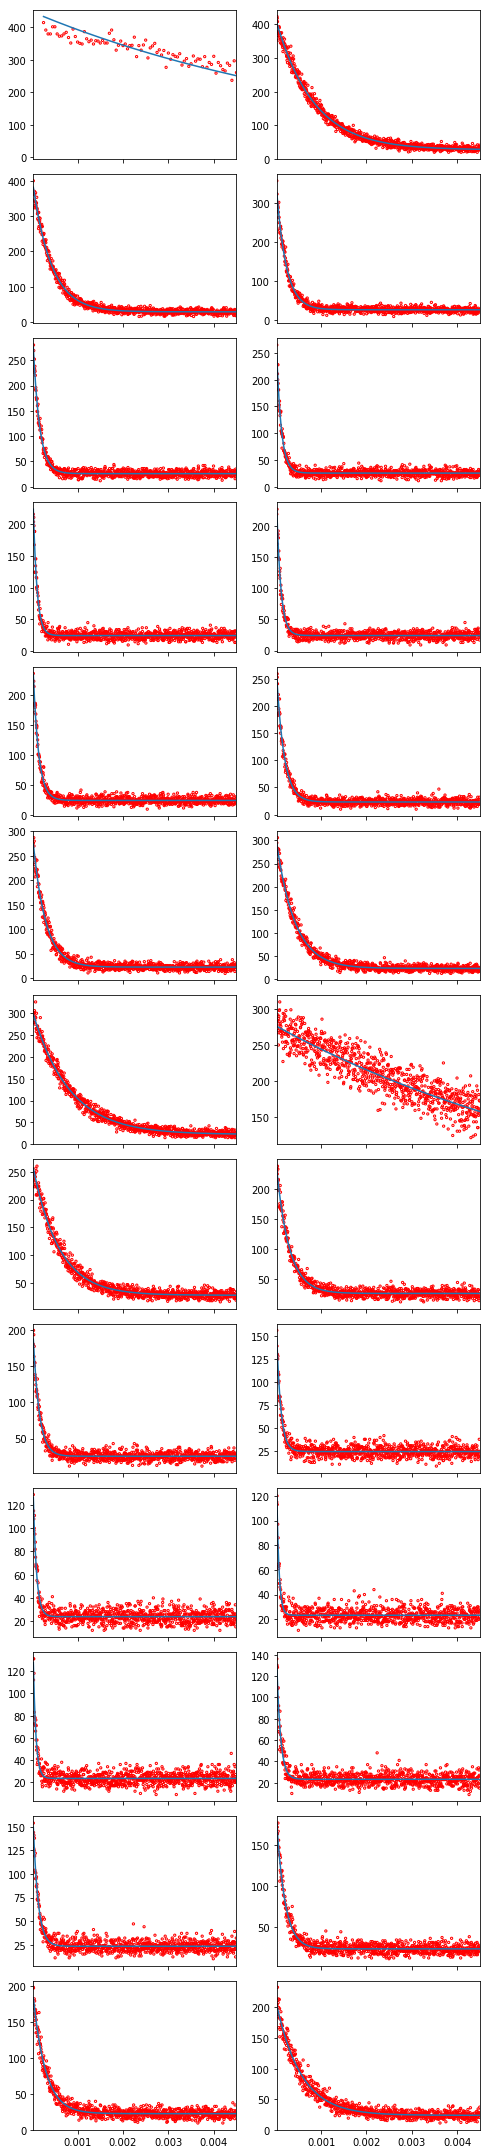

In [30]:
f3 = ""
filelist3 = []
save_arr = []
data_arr = []
#sigma_arr = []
time_arr = []
fit_arr = []
fit_file = "FIT_Coeffs.txt"
err_file = "Fit_Uncert.txt"
summ_file3 = "DAT_Summary.txt"
NoSave = True

def div0( a, b ):
    #""" ignore / 0, div0( [-1, 0, 1], 0 ) -> [0, 0, 0] """
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.true_divide( a, b )
        c[ ~ np.isfinite( c )] = 1  # -inf inf NaN
    return c

#fit function
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

#fit function
def dexp_func(x, a, b, c, f, g):
    return (a * np.exp(-b * x)) + (f * np.exp(-g * x)) + c


#Find all flies with "".dat" ending
for file in sorted(os.listdir(os.getcwd())):
    if file.endswith(".dat"):
        f3 = str(file)
        filelist3 = np.append(filelist3, f3)

# print(filelist3)
        
#set up plot...
plot_row = int((filelist3.size+plot_col//2)//plot_col)
f, axarr = plt.subplots(plot_row,plot_col, figsize=((plot_col*4),(plot_row*3)),sharex=True)
axarr = axarr.ravel()

#For loop to extract data from each file and build save file list
for idx, item in enumerate(filelist3):

    #build temporary list with data
    temp_arr = []
    temp_arr = np.genfromtxt(item, delimiter = '\t', dtype = 'str',)

    #convert data array to float for fitting - consider changing to import directly as float?!
    temp_arr = temp_arr.astype(np.float)
    time_arr, data_arr = np.hsplit(temp_arr, 2)	
    time_arr = time_arr.flatten()
    data_arr = data_arr.flatten()

    #trim the data array (sometimes the first few data points are rubbish) - currently 15 data points
    #data_arr = np.delete(data_arr, [0,1,2,3,4,5,6,7,8,9,10])

    data_arr = data_arr[time_idx_st:time_idx_en]
    time_arr = time_arr[time_idx_st:time_idx_en]
    #generate x axis (time)

    """time_arr = np.zeros(len(data_arr))
    for i in range(0,len(time_arr)):
        time_arr[i] = i*(time_step*1e-6)

    #sigma = div0(1, data_arr)"""

    #fit data with func()
    popt, pcov = curve_fit(func, time_arr, data_arr, p0=(500,4000,20)) #, sigma=sigma, absolute_sigma=True
    error = [] 
    for i in range(len(popt)):
        try:
            error.append(np.absolute(pcov[i][i])**0.5)
        except:
            error.append( 0.00 )
    perr_curvefit = np.array(error)
    
    axarr[idx].scatter(time_arr, data_arr, s=5, facecolors='none', edgecolors='r')
    axarr[idx].set_xlim([np.amin(time_arr),np.amax(time_arr)])
    axarr[idx].plot(time_arr, func(time_arr,*popt))
    
    
    #if there's no save list yet, then set first set of data to save_arr. Otherwise, stack temp_arr with save_arr
    if NoSave:
        fit_arr = popt
        save_arr = data_arr
        err_arr = perr_curvefit
        NoSave = False
    else:
        save_arr = np.column_stack((save_arr,data_arr))
        err_arr = np.vstack((err_arr,perr_curvefit))
        fit_arr = np.vstack((fit_arr,popt))

#save data to text file.
save_file = open(summ_file3, 'wb')
np.savetxt(save_file, save_arr, delimiter = '\t',fmt="%s")
save_file.close()

#save fit coeffs to file
save_file = open(fit_file, 'wb')
np.savetxt(save_file, fit_arr, delimiter = '\t',fmt="%s")
save_file.close()
#save fit uncerts to file
save_file = open(err_file, 'wb')
np.savetxt(save_file, err_arr, delimiter = '\t',fmt="%s")
save_file.close()

#plot data
f.subplots_adjust(hspace=.1)
#plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
plt.savefig('Data fit.png')


# Analysis

Average Pressure, Torr =
613.4
Average Temperature, K =
295.34
               1
0     137.801470
1    1209.507285
2    2437.327429
3    4679.395128
4    7027.563376
5    9655.172356
6   12128.614185
7   10756.373739
8    8341.296893
9    6052.542448
10   3617.419622
11   2455.755315
12   1237.481519
13    125.306850
14   1747.851010
15   3570.761682
16   7442.202741
17  10883.753930
18  13852.211261
19  19815.470200
20  17070.691427
21  11878.734510
22   9145.536801
23   5371.681848
24   3642.114974
25   1841.648948


,NO Concentration,1
0,0.000000e+00,137.801470
1,1.579547e+14,1209.507285
2,1.561118e+14,2437.327429
3,3.064111e+14,4679.395128
4,6.144539e+14,7027.563376
5,9.201315e+14,9655.172356
6,1.223216e+15,12128.614185
7,1.524133e+15,10756.373739
8,1.373564e+15,8341.296893
9,1.071726e+15,6052.542448


ValueError: x and y must have same first dimension, but have shapes (27,) and (26, 1)

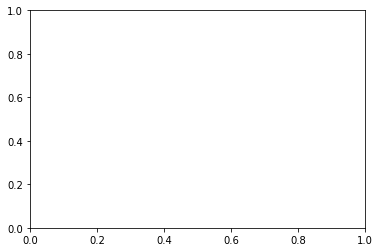

In [32]:
file_name = 'Analysis_121718_RT_740Torr' # Name of the Excel file

# Drop_runs_start=1  
# Drop_runs_end=26     #Use these variables to seperate data sets

# Drop_runs_start=Drop_runs_start-1
# Drop_runs_end=Drop_runs_end-1
data_avg = pd.read_table('AVG_Summary.txt',header=0)
data_avg.drop(data_avg.iloc[:,1:17],inplace = True,axis = 1)
data_avg.drop(data_avg.iloc[:,15:19],inplace = True,axis = 1)
data_avg.drop(data_avg.iloc[:,17:31],inplace = True,axis = 1)

data_avg['NO Concentration'] = data_avg['Actual Flow: NO2']/(data_avg['Actual Flow: HNO3 Bubbler']+
    data_avg['Actual Flow: N2 small 2']+data_avg['Actual Flow: NO2']+data_avg['Actual Flow: N2 Small']+
    data_avg['Actual Flow: N2 Purge']+data_avg['Actual Flow: N2'])*data_avg['Pressure: Chamber Do']/(data_avg['Temperature: Chamber']+273.15)*9.6e18*mix/100

print('Average Pressure, Torr =') 
print(round(data_avg["Pressure: Chamber Do"].mean(),2))
print('Average Temperature, K =') 
print(round(data_avg["Temperature: Chamber"].mean()+273.15,2))

data_fit = pd.read_table('FIT_Coeffs.txt', header =-1)
data_fit_err = pd.read_table('Fit_Uncert.txt',header=-1)
data_fit.drop(data_fit.columns[[0,2]],inplace = True,axis = 1)
data_fit_err.drop(data_fit_err.columns[[0,2]],inplace = True,axis = 1)

#These are built in in the case of multiple conditions taken in the same day
# x_data.drop(x_data.index[Drop_runs_start:Drop_runs_end],inplace=True) 
# y_data.drop(y_data.index[Drop_runs_start:Drop_runs_end],inplace=True) 

x_data=data_avg['NO Concentration']
y_data=data_fit
# y_data.drop(y_data.index[1])

print(y_data)

# Make table output
xy=pd.concat([x_data,y_data], axis =1)
# xy.drop(xy.index[Drop_runs_start:Drop_runs_end],inplace=True) 
display(xy)

writer = pd.ExcelWriter(file_name + '.xls')
data_avg.to_excel(writer,'Avg_Summary')
xy.to_excel(writer,"Analysis")
writer.save()

# Make a plot of the data
plt.plot(x_data,y_data, 'ro') 
plt.xlabel('Concentration, molecules / cm3')
plt.ylabel('k')

# Make Linear Fit
(m,b) = polyfit(x_data, y_data, 1)
print('slope =')
print(m)
print('intercept = ')
print(b)
z = polyval([m,b], x_data)
plot(x_data, z, 'k--')
plt.savefig('linear_fit.png')
show()

